# LightFM - hybrid matrix factorisation on MovieLens (Python, CPU)

## 1. Hybrid matrix factorisation model

## 2. Movie recommender with LightFM using only explicit feedbacks

### 2.1 Import libraries

In [1]:
import sys
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import (
    precision_at_k, recall_at_k)

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


System version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
LightFM version: 1.16


### 2.2 Defining variables

In [2]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# seed for pseudonumber generations
SEEDNO = 42


### 2.2 Retrieve data

In [3]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"]
)
# quick look at the data
data.sample(5)

100%|██████████| 4.81k/4.81k [00:11<00:00, 423KB/s]  


,userID,itemID,rating,genre
54439,269,142,1.0,Adventure|Children's|Musical
86685,10,629,4.0,Comedy|Musical
870,263,265,4.0,Action|Thriller
90925,195,500,4.0,Adventure|Children's
54055,846,57,2.0,Drama


### 2.3 Prepare data

In [4]:
# Before fitting the LightFM model, we need to create an instance of Dataset which holds the interaction matrix.
dataset = Dataset()

# The fit method creates the user/item id mappings.
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


In [5]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

In [6]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

In [7]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


### 2.4 Fit the LightFM model

In [8]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEEDNO))
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### 2.5 Prepare model evaluation data

In [10]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEEDNO))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 1.5 seconds for prepare and predict test data.


In [11]:
test_df.sample(5)

,userID,itemID,rating
4141,328,708,2.0
3207,178,69,5.0
12373,501,108,4.0
8669,303,294,4.0
2146,406,826,3.0


In [12]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 311.3 seconds for prepare and predict all data.


In [13]:
all_predictions.sample(5)

,userID,itemID,prediction
309679,352,660,38.796818
864828,84,687,-10.838598
93577,40,1674,-27.530016
724867,267,785,-24.626528
823444,162,1659,-31.667686


### 2.6 Model evaluation

In [14]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, 
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, 
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, 
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval
    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}", 
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using LightFM evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056


## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

## 3.1 Extract and prepare movie genres

In [15]:
# split the genre based on the separator
movie_genre = [x.split('|') for x in data['genre']]

# retrieve the all the unique genres in the data
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
# quick look at the all the genres within the data
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

## 3.2 Retrieve and prepare movie genres

### 3.2.1 Retrieve and merge data 

In [16]:
user_feature_URL = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.user'
user_data = pd.read_table(user_feature_URL, 
              sep='|', header=None)
user_data.columns = ['userID','age','gender','occupation','zipcode']

# merging user feature with existing data
new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
# quick look at the merged data
new_data.sample(5)

,userID,itemID,rating,genre,occupation
10207,655,527,3.0,Drama,healthcare
43397,798,491,4.0,Action|Adventure,writer
32228,389,955,4.0,Drama|Romance,writer
86121,121,347,3.0,Comedy|Drama,librarian
49345,682,1311,3.0,Comedy|Drama,programmer


### 3.2.2 Extract and prepare user occupations

In [17]:
# retrieve all the unique occupations in the data
all_occupations = sorted(list(set(new_data['occupation'])))

## 3.3 Prepare data and features

In [20]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_movie_genre,
            user_features=all_occupations)

item_features = dataset2.build_item_features(
    (x, y) for x,y in zip(data.itemID, movie_genre))

user_features = dataset2.build_user_features(
    (x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

(interactions2, weights2) = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

## 3.3 Fit the LightFM model with additional user and item features

In [21]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEEDNO))
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS);

## 3.4 Prepare model evaluation data

In [22]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, interactions2.col, interactions2.data, 
    random_state=np.random.RandomState(SEEDNO))

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 1.5 seconds for prepare and predict test data.


In [23]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 140.3 seconds for prepare and predict all data.


## 3.5 Model evaluation and comparison

In [24]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using both implicit and explicit ratings ------
Precision@K:	0.143372
Recall@K:	0.051515


## 3.6 Evaluation metrics comparison

In [25]:
print(
    "------ Using Repo's evaluation methods ------",
    f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Time [sec]:\t{time_lfm:.1f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Time [sec]:	317.1

------ Using LightFM evaluation methods ------
Time [sec]:	0.3


# 4. Evaluate model fitting process

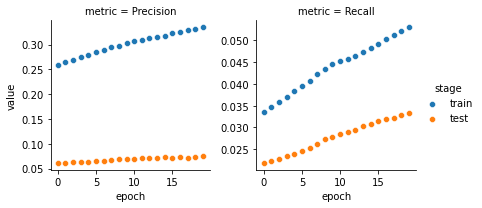

In [26]:
output1, _ = track_model_metrics(model=model1, train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS)

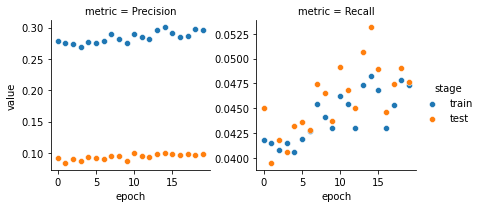

In [27]:
output2, _ = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS, 
                              item_features=item_features,
                              user_features=user_features)

## 4.1 Performance comparison

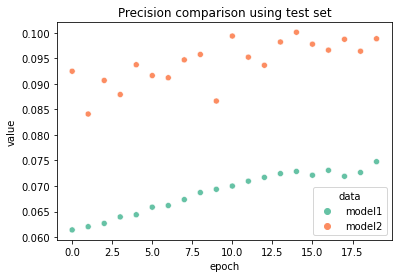

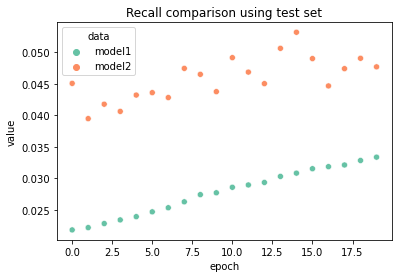

In [28]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

# 5. Similar users and items

## 5.1 User affinity

In [29]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[ 0.05855272, -1.0679566 ,  1.546727  , ...,  3.397634  ,
        -2.949106  ,  4.1061826 ],
       [-0.46352172,  0.6082267 ,  2.6320086 , ...,  3.8771079 ,
        -4.569986  ,  4.283195  ],
       [-0.05073825,  1.9805118 ,  1.2392372 , ...,  1.5033078 ,
        -5.9772434 ,  4.982345  ],
       ...,
       [ 1.6734635 , -1.2261837 ,  2.5265899 , ...,  2.617263  ,
        -2.8289523 ,  3.682522  ],
       [-0.46174836,  0.60860467,  2.5804837 , ...,  3.7958286 ,
        -4.4355407 ,  4.138396  ],
       [-0.9511113 ,  1.4378088 ,  1.9738803 , ...,  3.6424727 ,
        -4.401794  ,  4.9400377 ]], dtype=float32)

In [30]:
similar_users(user_id=1, user_features=user_features, 
            model=model2)

,userID,score
0,555,0.999999
1,54,0.999999
2,314,0.999997
3,395,0.999996
4,465,0.999996
5,481,0.999995
6,527,0.999993
7,282,0.999993
8,411,0.999992
9,881,0.999991


## 5.2 Item affinity

In [31]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[ 0.2480127 ,  0.2852422 ,  0.41805026, ...,  0.50482327,
        -0.72950274,  0.69199866],
       [ 0.15941173,  0.26332796,  0.5312104 , ...,  0.67708844,
        -0.6556045 ,  0.70197904],
       [ 0.17083699,  0.43052566,  0.4654963 , ...,  0.5021669 ,
        -0.6872691 ,  0.5713904 ],
       ...,
       [ 0.31632525, -0.00241148,  0.2915753 , ...,  0.05674869,
        -0.13216934,  0.05792239],
       [-0.36782396, -0.3278999 ,  0.42307836, ...,  0.8439833 ,
        -0.27845436,  0.6473619 ],
       [-0.09946227, -0.25418764,  0.5964439 , ...,  0.51661193,
        -0.45929876,  0.5635988 ]], dtype=float32)

In [32]:
similar_items(item_id=10, item_features=item_features, 
            model=model2)

,itemID,score
0,417,0.999105
1,12,0.998332
2,231,0.998319
3,182,0.998289
4,474,0.998247
5,76,0.998171
6,253,0.998157
7,373,0.998125
8,573,0.998029
9,296,0.998021
